## Import Libraries

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

## Read CSV Files

In [2]:
no_retract = pd.read_csv('./no_retraction_data_plos_only_cleaned.csv')
no_retract = no_retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

retract = pd.read_csv('./retraction_data_plos_only_cleaned.csv')
retract = retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [3]:
total = pd.read_csv('./total_data_plos_only_cleaned.csv')
total = total.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
total.head()

,doi,year,month,day,volume,issue,journal,title,text,abstract,keywords,retraction_binary,unpacked_keywords,clean_text,clean_text_lem
0,10.1208/s12249-016-0596-x,2016.0,8.0,10.0,18.0,5.0,AAPS PharmSciTech,Study of the Transformations of Micro/Nano-cry...,‘Polymorphism’ generally referred as the abili...,This study elucidates the physical properties ...,"['monoclinic', 'nano-sized crystals', 'orthorh...",1,"['monoclinic', 'nano-sized', 'crystals', 'orth...",Polymorphism generally referred as the ability...,Polymorphism generally referred a the ability ...
1,10.1021/acscentsci.9b00224,2019.0,5.0,9.0,5.0,6.0,ACS central science,Targeted Protein Internalization and Degradati...,Traditional\ndrug development efforts are focu...,Targeted,[],1,[],Traditional drug development efforts are focus...,Traditional drug development effort are focuse...
2,10.1021/acsomega.8b00488,2018.0,6.0,27.0,3.0,6.0,ACS omega,Regulating the Microstructure of Intumescent F...,Intumescent flame retardants\nare now being us...,A compatibilizer,[],1,[],Intumescent flame retardants are now being use...,Intumescent flame retardant are now being used...
3,10.1021/acsomega.8b00153,2018.0,6.0,25.0,3.0,6.0,ACS omega,Solid-to-Solid Crystallization of Organic Thin...,Crystal growth process is basic and essential ...,The solid-to-solid crystallization processes o...,[],1,[],Crystal growth process is basic and essential ...,Crystal growth process is basic and essential ...
4,10.1107/S1600536811022574,2011.0,6.0,18.0,67.0,NaN,"Acta crystallographica. Section E, Structure r...",Oxonium picrate.,For general background to organic salts of pic...,"The title compound, H3O+·C6H2N3O7",[],1,[],For general background to organic salts of pic...,For general background to organic salt of picr...


## Determining Best Decision Tree Model

### Initializing Models

In [65]:
lemmatizer = WordNetLemmatizer()
lem_stopwords = [lemmatizer.lemmatize(i) for i in stopwords.words("english")]

retraction_stopwords = ['wa', 'using', 'et', 'al', 'figure', 'usepackage', 'used', 'fig', 'also', 
                        'ml', 'ha', 'two', 'one', 'may', 'based', 'table', 'however', 'data', 'mm', 'ms']

lem_retraction_stopwords = [lemmatizer.lemmatize(i) for i in retraction_stopwords]

#https://www.quora.com/Is-there-any-list-of-stopwords-related-to-scientific-papers
science_stopwords = ['any','apply','applying','reapplying','given','papers','paper','about',
                     'results','result','real','world','page','article','present','takes',
                     'account', 'previous','work','propose','proposes','proposed','simply','simple',
                     'demonstrate','demonstrated','demonstrates','realworld','datasets','dataset',
                     'provide','important','research','researchers','experiments','experiment','unexpected',
                     'discovering','using','recent','collected','solve','columns','existing','traditional',
                     'final','consider','presented','provides','automatically','extracting','including','help',
                     'helps','explore','illustrate','achieve','better']

lem_science_stopwords = [lemmatizer.lemmatize(i) for i in science_stopwords]

total_stopwords = stopwords.words("english") + lem_stopwords + retraction_stopwords + lem_retraction_stopwords + science_stopwords + lem_science_stopwords

In [66]:
X = total['clean_text_lem']
y = total['retraction_binary']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [8]:
y_test.value_counts(normalize=True).mul(100).round(2)

0    85.54
1    14.46
Name: retraction_binary, dtype: float64

In [9]:
X = total['clean_text_lem']
y = total['retraction_binary']

In [20]:
def vectorizer_setup(test_size_value, vectorizer_setting, stop_words_lists, 
                     max_features_values, gram_setting, model_type):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size = test_size_value)
    
    if vectorizer_setting == 'CountVectorizer':
        vectorizer = CountVectorizer(analyzer = 'word',
                                     tokenizer = None,
                                     preprocessor = None,
                                     stop_words = stop_words_lists,
                                     max_features = max_features_values)
    else:
        vectorizer = TfidfVectorizer(ngram_range = gram_setting, 
                               max_features = max_features_values, 
                               stop_words = stop_words_lists)
    
    vectorizer.fit(X_train)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=vectorizer.get_feature_names())
    X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())
    
    if model_type == 'dtc':
        dtc = DecisionTreeClassifier()
        dtc.fit(X_train_df, y_train)

        print(f'Score on training set: {dtc.score(X_train_df, y_train).round(3)}')
        print(f'Score on testing set: {dtc.score(X_test_df, y_test).round(3)}')
        
        plot_confusion_matrix(dtc, X_test_df, y_test, cmap='Blues', values_format='d');
        
    elif model_type == 'dtc_max_depth':
        dtc = DecisionTreeClassifier(max_depth = 5)
        dtc.fit(X_train_df, y_train)

        print(f'Score on training set: {dtc.score(X_train_df, y_train).round(3)}')
        print(f'Score on testing set: {dtc.score(X_test_df, y_test).round(3)}')
        
        plot_confusion_matrix(dtc, X_test_df, y_test, cmap='Blues', values_format='d');
    
    elif model_type == 'bag':
        base_tree = DecisionTreeClassifier()

        bag = BaggingClassifier(base_estimator=base_tree,
                                bootstrap = True,
                                random_state=42)

        bag.fit(X_train_df, y_train)
        print(f'Score on training set: {bag.score(X_train_df, y_train)}')
        print(f'Score on testing set: {bag.score(X_test_df, y_test)}')

        plot_confusion_matrix(bag, X_test_df, y_test, cmap='Blues', values_format='d');
        
    elif model_type == 'rfc':
        rfc = RandomForestClassifier(random_state = 42)

        rfc.fit(X_train_df, y_train)
        print(f'Score on training set: {rfc.score(X_train_df, y_train)}')
        print(f'Score on testing set: {rfc.score(X_test_df, y_test)}')

        plot_confusion_matrix(rfc, X_test_df, y_test, cmap='Blues', values_format='d');
        
    else:
        base_tree = DecisionTreeClassifier()

        ada = AdaBoostClassifier(base_estimator=base_tree,
                         random_state=42)

        ada.fit(X_train_df, y_train)
        print(f'Score on training set: {ada.score(X_train_df, y_train)}')
        print(f'Score on testing set: {ada.score(X_test_df, y_test)}')

        plot_confusion_matrix(ada, X_test_df, y_test, cmap='Blues', values_format='d');
    
    return 

### Decision Tree

Score on training set: 1.0
Score on testing set: 0.908


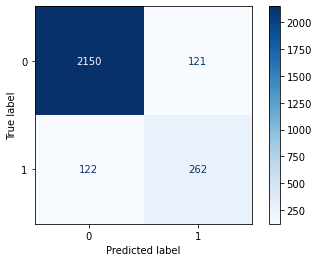

In [22]:
vectorizer_setup(0.25, 'CountVectorizer', total_stopwords, 20000, None, 'dtc')

Score on training set: 1.0
Score on testing set: 0.893


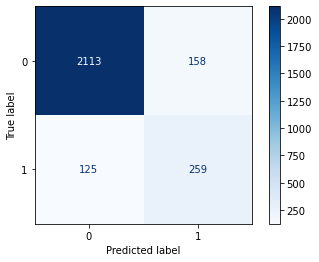

In [23]:
vectorizer_setup(0.25, 'TfidfVectorizer', total_stopwords, 5000, (1,2), 'dtc')

Score on training set: 0.938
Score on testing set: 0.922


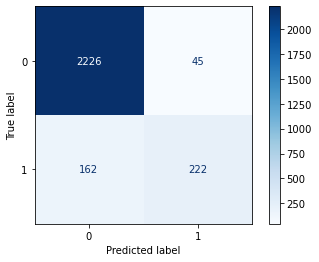

In [24]:
vectorizer_setup(0.25, 'CountVectorizer', total_stopwords, 20000, None, 'dtc_max_depth')

Score on training set: 0.915
Score on testing set: 0.898


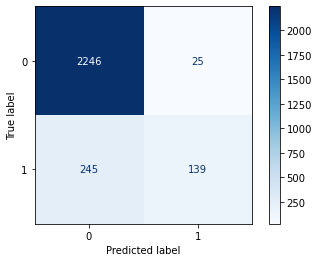

In [25]:
vectorizer_setup(0.25, 'TfidfVectorizer', total_stopwords, 5000, (1,2), 'dtc_max_depth')

Score on training set: 0.938
Score on testing set: 0.922


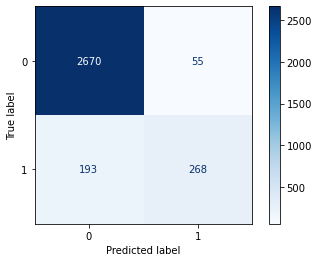

In [26]:
vectorizer_setup(0.3, 'CountVectorizer', total_stopwords, 20000, None, 'dtc_max_depth')

Score on training set: 0.915
Score on testing set: 0.903


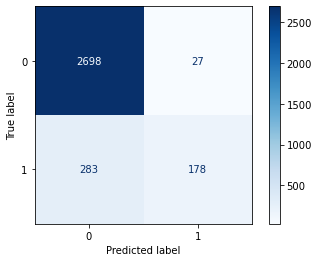

In [27]:
vectorizer_setup(0.3, 'TfidfVectorizer', total_stopwords, 5000, (1,2), 'dtc_max_depth')

### Bagging

Score on training set: 0.9922149673530889
Score on testing set: 0.9344632768361582


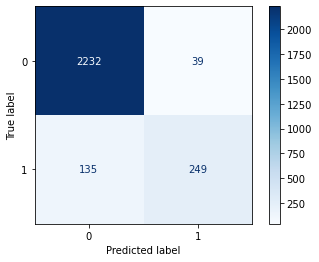

In [28]:
vectorizer_setup(0.25, 'CountVectorizer', total_stopwords, 20000, None, 'bag')

Score on training set: 0.9938473129080864
Score on testing set: 0.9318267419962335


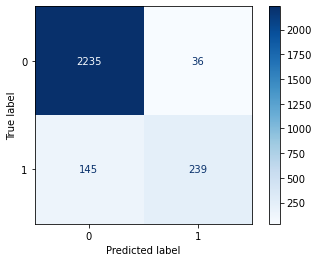

In [29]:
vectorizer_setup(0.25, 'TfidfVectorizer', total_stopwords, 5000, (1,2), 'bag')

### Random Forest

Score on training set: 1.0
Score on testing set: 0.8990583804143126


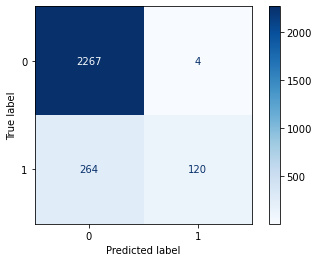

In [30]:
vectorizer_setup(0.25, 'CountVectorizer', total_stopwords, 20000, None, 'rfc')

Score on training set: 0.9998744349573079
Score on testing set: 0.9096045197740112


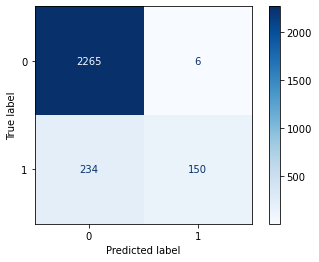

In [31]:
vectorizer_setup(0.25, 'TfidfVectorizer', total_stopwords, 5000, (1,2), 'rfc')

### AdaBoost

Score on training set: 1.0
Score on testing set: 0.903954802259887


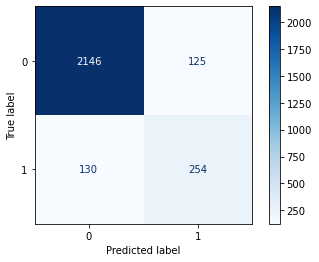

In [32]:
vectorizer_setup(0.25, 'CountVectorizer', total_stopwords, 20000, None, 'ada')

## Further Exploring Chosen Decision Tree Model

### Most Common Bigrams

In [33]:
tvec = TfidfVectorizer(ngram_range=(2, 2), max_features=5000, 
                       stop_words = total_stopwords)

X_train_df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
X_test_df = pd.DataFrame(tvec.transform(X_test).toarray(),
                  columns=tvec.get_feature_names())

#### Retractions

In [35]:
tvec.fit(retract['clean_text_lem'])
vect = tvec.transform(retract['clean_text_lem'])
vect_retract = pd.DataFrame(vect.toarray(), columns = tvec.get_feature_names())

In [36]:
ls = []
for i in vect_retract.columns:
    word_sum = vect_retract[i].sum()
    ls.append(word_sum) #create a list of the total number of times each word was used

#The script below was adapted from https://www.kite.com/python/answers/how-to-append-a-list-as-a-row-to-a-pandas-dataframe-in-python
sum_row = pd.Series(ls, index = vect_retract.columns) #the list was turned into a series
vect_retract = vect_retract.append(sum_row, ignore_index = True) #the series was added to the end of the dataframe as a new row
vect_retract.tail()

,10x chromium,10x genomics,10x scrna,126a 3p,12pt minimal,13c nmr,16s rrna,1a cell,1a cu2,1h 1h,...,μl 1x,μl dmem,μm min,μm pb,μm scr7,μm w9,μm μm,νmax cm,χ2 test,ψh ψh
1533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058206,0.000000
1534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1535,0.000000,0.000000,0.000000,0.000000,0.050547,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1537,0.161599,0.233421,0.287287,0.642817,4.689118,2.138577,2.900592,0.491354,0.386392,0.519539,...,0.170187,0.425449,1.05716,0.231807,0.179555,0.636523,3.353947,0.235546,2.074697,0.323198


In [37]:
vect_retract.iloc[1537, :].sort_values(ascending=False).head(25)

cell line                    31.509112
control group                29.071377
significant difference       26.456188
mg kg                        24.097655
cancer cell                  23.828528
breast cancer                21.376787
wild type                    21.330044
statistically significant    20.840092
western blot                 20.085729
year old                     20.011517
meta analysis                19.324355
nf κb                        18.698282
long term                    17.231212
expression level             16.885402
cell cycle                   16.137679
blood pressure               15.634200
compared control             15.515948
room temperature             15.285657
gene expression              15.018492
amino acid                   14.820755
additional file              14.552867
risk factor                  14.454372
standard deviation           14.195035
cell proliferation           13.580018
significantly higher         13.391417
Name: 1537, dtype: float6

#### No Retractions

In [39]:
tvec.fit(no_retract['clean_text_lem'])
vect = tvec.transform(no_retract['clean_text_lem'])
vect_no_retract = pd.DataFrame(vect.toarray(), columns = tvec.get_feature_names())

In [40]:
ls = []
for i in vect_no_retract.columns:
    word_sum = vect_no_retract[i].sum()
    ls.append(word_sum) #create a list of the total number of times each word was used

#The script below was adapted from https://www.kite.com/python/answers/how-to-append-a-list-as-a-row-to-a-pandas-dataframe-in-python
sum_row = pd.Series(ls, index = vect_no_retract.columns) #the list was turned into a series
vect_no_retract = vect_no_retract.append(sum_row, ignore_index = True) #the series was added to the end of the dataframe as a new row
vect_no_retract.tail()

,13c nmr,16s rrna,18f fdg,18s rrna,1a 1b,1b 1c,1c 1d,1h arh,1h nmr,1x pbs,...,μl pbs,μl reaction,μl sample,μl well,μl μl,μm respectively,μm thick,μm μm,χ2 df,χ2 test
9078,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9079,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9080,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9081,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9082,4.25743,30.501089,7.681026,7.081566,15.98676,9.428966,9.249353,0.362868,8.501771,5.850962,...,7.423554,10.382723,8.37116,8.135361,7.308911,7.247525,9.190321,31.611839,13.276746,15.011524


In [41]:
vect_no_retract.iloc[9082, :].sort_values(ascending=False).head(25)

additional file              161.384336
click additional             161.285763
significant difference       154.234613
amino acid                   124.152065
wild type                    118.845781
control group                114.117008
gene expression              107.418578
standard deviation           104.181972
statistically significant    103.825676
cell line                    100.624951
risk factor                   95.061570
time point                    92.247410
confidence interval           87.066016
analysis performed            85.510281
mg kg                         84.804689
significantly higher          82.055180
sample size                   79.774721
expression level              77.962911
logistic regression           74.807535
male female                   73.838470
s1 file                       73.295150
previously described          72.642214
meta analysis                 72.617060
pdf click                     72.568815
year old                      72.457221


### Most Common Single Words

In [68]:
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = total_stopwords,
                            max_features = 20000)

vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())

#### Retractions

In [69]:
vectorizer.fit(retract['clean_text_lem'])
vect = vectorizer.transform(retract['clean_text_lem'])
vect_retract = pd.DataFrame(vect.toarray(), columns = vectorizer.get_feature_names())

In [70]:
ls = []
for i in vect_retract.columns:
    word_sum = vect_retract[i].sum()
    ls.append(word_sum) #create a list of the total number of times each word was used

#The script below was adapted from https://www.kite.com/python/answers/how-to-append-a-list-as-a-row-to-a-pandas-dataframe-in-python
sum_row = pd.Series(ls, index = vect_retract.columns) #the list was turned into a series
vect_retract = vect_retract.append(sum_row, ignore_index = True) #the series was added to the end of the dataframe as a new row
vect_retract.tail()

,000x,011figure,012a,013figure,01the,01to,0a,0d0,0d8,103rkocolon0,...,χ2,χn,χγ,χζ,ψb,ψh,ψp,ωu2,ϵ0,ϵqph
1533,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1536,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0
1537,42,34,42,32,32,42,40,108,34,30,...,836,112,112,112,196,1176,420,54,198,56


In [71]:
vect_retract.iloc[1537, :].sort_values(ascending=False).head(50)

cell             128810
study             42884
group             40348
level             39027
patient           37508
expression        35759
control           35270
protein           31496
analysis          27986
gene              26404
time              26017
treatment         24966
effect            24135
antibody          21716
vitamin           20472
mouse             19963
sample            19096
compared          18733
different         17579
significant       17245
value             17214
concentration     17061
model             17035
well              17003
day               16819
high              16804
disease           16737
performed         16691
shown             16551
significantly     16392
response          16061
activity          15977
mean              15827
cancer            15551
three             15214
treated           15194
test              15174
showed            15075
tissue            14903
number            14850
hiv               14562
increased       

#### No Retractions

In [72]:
vectorizer.fit(no_retract['clean_text_lem'])
vect = vectorizer.transform(no_retract['clean_text_lem'])
vect_no_retract = pd.DataFrame(vect.toarray(), columns = vectorizer.get_feature_names())

In [73]:
ls = []
for i in vect_no_retract.columns:
    word_sum = vect_no_retract[i].sum()
    ls.append(word_sum) #create a list of the total number of times each word was used

#The script below was adapted from https://www.kite.com/python/answers/how-to-append-a-list-as-a-row-to-a-pandas-dataframe-in-python
sum_row = pd.Series(ls, index = vect_no_retract.columns) #the list was turned into a series
vect_no_retract = vect_no_retract.append(sum_row, ignore_index = True) #the series was added to the end of the dataframe as a new row
vect_no_retract.tail()

,000g,0h,0m,0mm,0t,0δnls,10,1000g,100g,100mg,...,σ1r,σ2,σi,τ1,τ2,φi,χ2,ϕ1,ϕ2,ϕi
9078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9082,290,143,138,161,154,256,186,171,297,200,...,197,414,250,243,286,187,3942,237,185,230


In [76]:
vect_no_retract.iloc[9082, :].sort_values(ascending=False).head(50)

cell             268720
study            260731
group            168998
analysis         161676
patient          147706
time             144462
level            142394
value            127528
model            127451
sample           119364
gene             117356
effect           117060
number           112058
control          108510
protein          105820
different        100419
test             100106
significant       98786
expression        95808
difference        91182
mean              89702
compared          85366
treatment         83195
high              82474
day               81410
three             80504
mouse             78121
performed         73236
higher            72547
found             72346
year              72083
shown             72014
total             71693
rate              70206
observed          70175
condition         69433
non               68626
type              68105
first             67409
change            67199
well              66928
method          

### Chosen Decision Tree Model

In [9]:
dtc = DecisionTreeClassifier()
model = dtc.fit(X_train_df, y_train)

In [20]:
print(export_text(dtc, list(X_train_df.columns)));

|--- declare <= 0.50
|   |--- µg <= 0.50
|   |   |--- click <= 0.50
|   |   |   |--- analysis <= 1.50
|   |   |   |   |--- number <= 3.50
|   |   |   |   |   |--- show <= 2.50
|   |   |   |   |   |   |--- please <= 0.50
|   |   |   |   |   |   |   |--- rate <= 8.50
|   |   |   |   |   |   |   |   |--- province <= 0.50
|   |   |   |   |   |   |   |   |   |--- dynamic <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- interpreted <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- interpreted >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- dynamic >  0.50
|   |   |   |   |   |   |   |   |   |   |--- improved <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- improved >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- provi

In [12]:
ls_features = []
ls_index = []
count = 0
for i in model.feature_importances_:
    if i != 0:
        ls_features.append(i)
        ls_index.append(count)
    count += 1
print(len(ls_features))
print(len(ls_index))

265
265


In [14]:
features = pd.DataFrame(ls_features, columns=['importance'])
features['index'] = ls_index

In [17]:
features['word'] = X_train_df.columns[[ls_index]]

In [28]:
features['importance'].sort_values(ascending = False).head(10)

55     0.217296
261    0.128258
40     0.083325
13     0.043033
86     0.035313
152    0.023676
21     0.020191
32     0.012620
174    0.009791
147    0.009322
Name: importance, dtype: float64

In [31]:
features.iloc[[55, 261, 40, 13, 86, 152, 21, 32, 174, 147], 2]

55      declare
261          µg
40        click
13     analysis
86      figures
152      number
21       author
32       cancer
174      please
147         non
Name: word, dtype: object